In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, skew

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.externals import joblib
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [4]:
train = pd.read_csv('../Datasets/house_value_estimation/train.csv')
test = pd.read_csv('../Datasets/house_value_estimation/test.csv')

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train = train.drop(train[train['Id'] == 1299].index)

In [8]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)
indata = pd.concat((train, test)).reset_index(drop=True)

In [10]:
indata.drop("Id", axis = 1, inplace = True)

In [11]:
indata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918 entries, 0 to 2917
Data columns (total 79 columns):
MSSubClass       2918 non-null int64
MSZoning         2914 non-null object
LotFrontage      2432 non-null float64
LotArea          2918 non-null int64
Street           2918 non-null object
Alley            198 non-null object
LotShape         2918 non-null object
LandContour      2918 non-null object
Utilities        2916 non-null object
LotConfig        2918 non-null object
LandSlope        2918 non-null object
Neighborhood     2918 non-null object
Condition1       2918 non-null object
Condition2       2918 non-null object
BldgType         2918 non-null object
HouseStyle       2918 non-null object
OverallQual      2918 non-null int64
OverallCond      2918 non-null int64
YearBuilt        2918 non-null int64
YearRemodAdd     2918 non-null int64
RoofStyle        2918 non-null object
RoofMatl         2918 non-null object
Exterior1st      2917 non-null object
Exterior2nd      2917 non

In [12]:
indata.select_dtypes(include='O').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [13]:
indata.select_dtypes(include='int64').head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,856,854,0,1710,...,0,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,1262,0,0,1262,...,1,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,920,866,0,1786,...,1,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,961,756,0,1717,...,1,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,1145,1053,0,2198,...,1,192,84,0,0,0,0,0,12,2008


In [14]:
indata.select_dtypes(include='float64').head()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,548.0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,460.0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,608.0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,642.0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,836.0


#### Handling null values 

In [15]:
indata["PoolQC"] = indata["PoolQC"].fillna("None")
indata["MiscFeature"] = indata["MiscFeature"].fillna("None")
indata["Alley"] = indata["Alley"].fillna("None")
indata["Fence"] = indata["Fence"].fillna("None")
indata["FireplaceQu"] = indata["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
indata["LotFrontage"] = indata.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    indata[col] = indata[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    indata[col] = indata[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    indata[col] = indata[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    indata[col] = indata[col].fillna('None')
    
indata["MasVnrType"] = indata["MasVnrType"].fillna("None")
indata["MasVnrArea"] = indata["MasVnrArea"].fillna(0)

indata['MSZoning'] = indata['MSZoning'].fillna(indata['MSZoning'].mode()[0])

indata = indata.drop(['Utilities'], axis=1)

indata["Functional"] = indata["Functional"].fillna("Typ")

indata['Electrical'] = indata['Electrical'].fillna(indata['Electrical'].mode()[0])

indata['KitchenQual'] = indata['KitchenQual'].fillna(indata['KitchenQual'].mode()[0])

indata['Exterior1st'] = indata['Exterior1st'].fillna(indata['Exterior1st'].mode()[0])
indata['Exterior2nd'] = indata['Exterior2nd'].fillna(indata['Exterior2nd'].mode()[0])

indata['SaleType'] = indata['SaleType'].fillna(indata['SaleType'].mode()[0])

indata['MSSubClass'] = indata['MSSubClass'].fillna("None")

In [16]:
indata.isnull().sum().max()

0

In [17]:
#MSSubClass=The building class
indata['MSSubClass'] = indata['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
indata['OverallCond'] = indata['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
indata['YrSold'] = indata['YrSold'].astype(str)
indata['MoSold'] = indata['MoSold'].astype(str)

In [18]:
indata.select_dtypes(include='O').columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [19]:
cols = indata.select_dtypes(include='O').columns

'''
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'BldgType', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')  '''

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(indata[c].values)) 
    indata[c] = lbl.transform(list(indata[c].values))

# shape        
print('Shape indata: {}'.format(indata.shape))

Shape indata: (2918, 78)


In [20]:
indata.select_dtypes(include='int64').describe()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,...,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000
mean,7.133310,3.027759,10149.704592,0.995888,0.985607,1.947567,2.777930,3.056888,0.053804,12.438999,...,16.067855,2.088074,2.993489,3.493489,1.065798,50.843386,6.510966,1.792666,7.491775,3.778615
std,3.698861,0.658468,7825.370357,0.064007,0.260136,1.409962,0.702632,1.603749,0.248791,5.958163,...,56.193208,34.555468,0.126768,1.091523,0.363470,567.498680,2.984886,1.315184,1.593536,1.078189
min,0.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,7477.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.000000,7.000000,...,0.000000,0.000000,3.000000,4.000000,1.000000,0.000000,5.000000,1.000000,8.000000,4.000000
50%,5.000000,3.000000,9452.500000,1.000000,1.000000,3.000000,3.000000,4.000000,0.000000,12.000000,...,0.000000,0.000000,3.000000,4.000000,1.000000,0.000000,7.000000,2.000000,8.000000,4.000000
75%,10.000000,3.000000,11561.250000,1.000000,1.000000,3.000000,3.000000,4.000000,0.000000,17.000000,...,0.000000,0.000000,3.000000,4.000000,1.000000,0.000000,9.000000,3.000000,8.000000,4.000000
max,15.000000,4.000000,215245.000000,1.000000,2.000000,3.000000,3.000000,4.000000,2.000000,24.000000,...,576.000000,800.000000,3.000000,4.000000,4.000000,17000.000000,11.000000,4.000000,8.000000,5.000000


In [ ]:
'''
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)
'''

In [21]:
indata[['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond']].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond
0,3,2,4,5,5
1,5,2,4,5,5
2,5,2,4,5,5
3,2,4,1,5,5
4,5,2,4,5,5


In [22]:
# Adding total sqfootage feature 
indata['TotalSF'] = indata['TotalBsmtSF'] + indata['1stFlrSF'] + indata['2ndFlrSF']

In [102]:
'''
numeric_feats = indata.select_dtypes(exclude=['O']).columns.values

# Check the skew of all numerical features
skewed_feats = indata[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
#print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
'''

#### Box Cox transformation

In [104]:
'''
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    indata[feat] = boxcox1p(indata[feat], lam)
'''    

There are 61 skewed numerical features to Box Cox transform


In [23]:
indata.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,10,3,65.0,8450,1,1,3,3,4,0,...,0,3,4,1,0,4,2,8,4,2566.0
1,5,3,80.0,9600,1,1,3,3,2,0,...,0,3,4,1,0,7,1,8,4,2524.0
2,10,3,68.0,11250,1,1,0,3,4,0,...,0,3,4,1,0,11,2,8,4,2706.0
3,11,3,60.0,9550,1,1,0,3,0,0,...,0,3,4,1,0,4,0,8,0,2473.0
4,10,3,84.0,14260,1,1,0,3,2,0,...,0,3,4,1,0,3,2,8,4,3343.0


In [63]:
indata = pd.get_dummies(indata)
indata.shape

(2918, 220)

In [26]:
train_df = indata[:ntrain]
test_df = indata[ntrain:]

#### Linear Regression

In [27]:
lr = LinearRegression()
lr.fit(train_df, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
pred = lr.predict(train_df)

In [29]:
print(rmsle(y_train, pred))
print(r2_score(y_train, pred))

27444.539196726488
0.8806488224055763


#### Decision Tree regressor

In [30]:
dtree = DecisionTreeRegressor()
dtree.fit(train_df,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [31]:
pred = dtree.predict(train_df)

print(rmsle(y_train, pred))
print(r2_score(y_train, pred))

0.0
1.0


In [51]:
pred = dtree.predict(test_df)

In [53]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.head()
sub.to_csv('./outputs/VHE_dtree_submission.csv',index=False)

#### Principal component analysis

In [95]:
pca = PCA(n_components=20)

In [96]:
train_pca =  pca.fit_transform(train_df)
test_pca = pca.fit_transform(test_df)

#### Random Forest Regressor

In [97]:
random_forest = RandomForestRegressor(n_jobs=-1)
#random_forest.fit(train_df,y_train)
random_forest.fit(train_pca,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [98]:
kfold = KFold(n_splits=10, shuffle=True)
#scores = cross_val_score(random_forest, train_df, y_train, cv = kfold)
scores = cross_val_score(random_forest, train_pca, y_train, cv = kfold)
print(scores)

[0.69073852 0.84732806 0.70289394 0.78266171 0.80256351 0.68272082
 0.79195555 0.82185546 0.55402443 0.77011317]


In [ ]:
pred = random_forest.predict(test_df)

In [99]:
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [6, 8],
    'min_samples_leaf': [5, 7, 9],
}

In [100]:
gs_cv = GridSearchCV(random_forest, param_grid, n_jobs=-1)

# Run the grid search - on only the training data!
#gs_cv.fit(train_df, y_train)
gs_cv.fit(train_pca,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [30, 50, 100], 'max_depth': [6, 8], 'min_samples_leaf': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
print(gs_cv.best_params_)

{'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 100}


In [102]:
#pred = gs_cv.predict(test_df)
pred = gs_cv.predict(test_pca)

In [103]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.head()
sub.to_csv('./outputs/house_value_estimation/rf_pca_gridsearch_submission.csv',index=False)

#### Gradient boost regressor

In [59]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [60]:
GBoost.fit(train_df, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=5, subsample=1.0, verbose=0,
             warm_start=False)

In [62]:
GBoost_train_pred = GBoost.predict(train_df)
#pred = np.expm1(GBoost.predict(test))
print(rmsle(y_train, GBoost_train_pred))

pred = GBoost.predict(test_df)

12304.647568541981


In [63]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.head()
sub.to_csv('./outputs/house_value_estimation/gb_submission.csv',index=False)

Text(0,0.5,'Feature Importance Score')

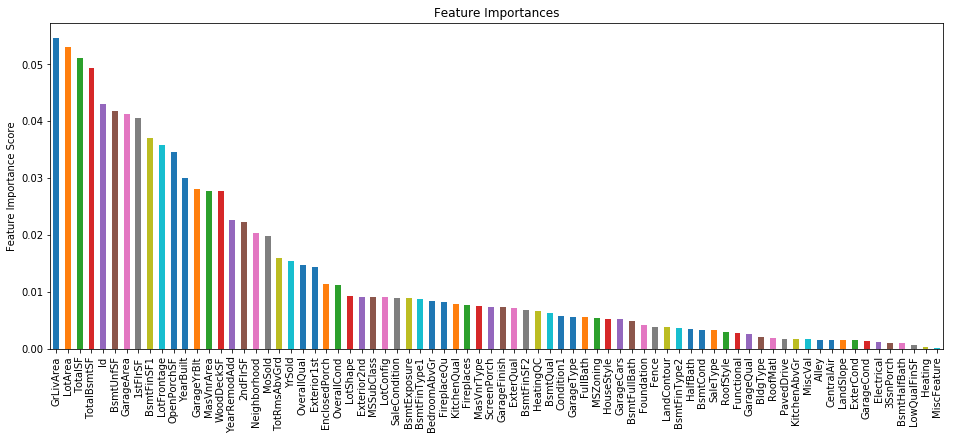

In [72]:
feat_imp = pd.Series(GBoost.feature_importances_, train_df.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [74]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

In [76]:
# Define the grid search we want to run. Run it with four cpus in parallel.
gs_cv = GridSearchCV(GBoost, param_grid, n_jobs=-1)

# Run the grid search - on only the training data!
gs_cv.fit(train_df, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=5, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 1000, 1500], 'max_depth': [4, 6], 'min_samples_leaf': [3, 5, 9, 17], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_features': [1.0, 0.3, 0.1], 'loss': ['ls', 'lad', 'huber']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [77]:
print(gs_cv.best_params_)

{'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 17, 'n_estimators': 1000}


In [79]:
#gscv_train_pred = gs_cv.predict(train_df)
#gscv_pred = np.expm1(gs_cv.predict(test.values))
pred = gs_cv.predict(test_df)

In [80]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.head()
sub.to_csv('./outputs/house_value_estimation/gb_gridsearch_submission.csv',index=False)

In [ ]:
# Find the error rate on the training set using the best parameters
mse = mean_absolute_error(y_train, gs_cv.predict(train))
print("Training Set Mean Absolute Error: %.4f" % mse)

# Find the error rate on the test set using the best parameters
#mse = mean_absolute_error(y_test, gs_cv.predict(test))
#print("Test Set Mean Absolute Error: %.4f" % mse)

In [ ]:
print("Model best Score: {}".format(round(gs_cv.best_score_,4)))
print('R squared: {}'.format(round(gs_cv.score(train, y_train),4)))

In [ ]:
coefficient_of_dermination = r2_score(y_train, gscv_train_pred )
coefficient_of_dermination

In [ ]:
mean_absolute_error(y_train, GBoost_train_pred)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))
print(mean_absolute_error(y_train, xgb_train_pred))

In [ ]:
xgb_pred = model_xgb.predict(test)

In [ ]:
print('R squared: {}'.format(round(model_xgb.score(train, y_train),4)))

In [ ]:
coefficient_of_dermination = r2_score(y_train, xgb_train_pred)
coefficient_of_dermination

In [33]:
import lightgbm as lgb

In [35]:
lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [36]:
lgb.fit(train_df, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.05, max_bin=55,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_data_in_leaf=6, min_split_gain=0.0, min_sum_hessian_in_leaf=11,
       n_estimators=720, n_jobs=-1, num_leaves=5, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
pred = lgb.predict(train_df)

#print('R squared: {}'.format(round(model_lgb.score(train, y_train),4)))
print(rmsle(y_train, pred))
print(r2_score(y_train, pred))

13350.250837978638
0.9717581154449422


In [39]:
pred = lgb.predict(test_df)

In [43]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [2, 4, 6],
    'min_child_weight': [0.001, 0.005, 0.01, 0.1],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'bagging_fraction': [0.5, 0.7, 0.9],
}

In [44]:
gs_cv = GridSearchCV(lgb, param_grid, n_jobs=-1)

# Run the grid search - on only the training data!
gs_cv.fit(train_df, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.05, max_bin=55,
       max_depth=-1, min_child_...=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 1000, 1500], 'max_depth': [2, 4, 6], 'min_child_weight': [0.001, 0.005, 0.01, 0.1], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'bagging_fraction': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
print(gs_cv.best_params_)

{'bagging_fraction': 0.5, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.001, 'n_estimators': 1500}


In [46]:
pred = gs_cv.predict(test_df)

In [47]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.head()
sub.to_csv('./outputs/house_value_estimation/lgb_gridsearch_submission.csv',index=False)

In [ ]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(y_train, lgb_train_pred)

print('Slope : {0} \n Intercept : {1} \n r2_value : {2} \n p_value : {3} \n std_err : {4}'
      .format(slope,intercept,r_value**2,p_value,std_err))